# Autoregressive Moving Average (ARMA)

In [3]:
import pandas as pd
import numpy as np

# Set to see all columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
csv_file = 'data/01_bronze/2011.csv'
df = pd.read_csv(csv_file)
df.shape

(6066650, 28)

# EDA

In [5]:
# Visualizamos informacion de la columna DEP_DELAY
df.DEP_DELAY.info()

# Contamos la cantidad de valores nulos
df.DEP_DELAY.isna().sum()

<class 'pandas.core.series.Series'>
RangeIndex: 6066650 entries, 0 to 6066649
Series name: DEP_DELAY
Non-Null Count    Dtype  
--------------    -----  
5954951 non-null  float64
dtypes: float64(1)
memory usage: 46.3 MB


111699

In [6]:
# Nos quedamos con los DEP_DELAY que tienen datos
df_dep_delay = df[df['DEP_DELAY'].notna()]
df_dep_delay.shape

(5954951, 28)

In [7]:
# Calculamos promedio de demora de partida por origen y dia (opcion 2)
df_mean_dep_delay = df_dep_delay.groupby(["ORIGIN", "FL_DATE"])\
    .agg(MEAN_DEP_DELAY=('DEP_DELAY', 'mean'))\
    .reset_index()

df_mean_dep_delay

,ORIGIN,FL_DATE,MEAN_DEP_DELAY
0,ABE,2011-01-01,10.166667
1,ABE,2011-01-02,1.125000
2,ABE,2011-01-03,-1.545455
3,ABE,2011-01-04,-3.000000
4,ABE,2011-01-05,-4.285714
...,...,...,...
92521,YUM,2011-12-27,-4.000000
92522,YUM,2011-12-28,-5.800000
92523,YUM,2011-12-29,-8.100000
92524,YUM,2011-12-30,17.625000


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# runtime configuration (rc) containing the default styles for every plot element
plt.rcParams['figure.figsize']=(16,6) 

## Analizamos el ORIGIN = JFK

In [9]:
# Nos quedamos con el aeropuerto de New York
data = df_mean_dep_delay[df_mean_dep_delay['ORIGIN']=='JFK']
data.drop(['ORIGIN'], axis=1, inplace=True)
data.set_index('FL_DATE', inplace=True)
data.index = pd.to_datetime(data.index)
#data = data.asfreq(pd.infer_freq(data.index))
data = data.asfreq('d')
data

,MEAN_DEP_DELAY
FL_DATE,
2011-01-01,18.922179
2011-01-02,37.205224
2011-01-03,25.735507
2011-01-04,10.766537
2011-01-05,3.801724
...,...
2011-12-27,40.489796
2011-12-28,7.547619
2011-12-29,5.587302


In [10]:
# Veamos cuantos datos faltan
print(f"Día sin promedios: {data.MEAN_DEP_DELAY.isna().sum()}")

Día sin promedios: 32


In [11]:
# Completamos los datos faltantes con el valor promedio de la columna
#data['MEAN_DEP_DELAY'] = data['MEAN_DEP_DELAY'].fillna(data['MEAN_DEP_DELAY'].mean())

# Last Observation Carried Forward
data['MEAN_DEP_DELAY'] = data['MEAN_DEP_DELAY'].ffill()

print(f"Día sin promedios: {data.MEAN_DEP_DELAY.isna().sum()}")

Día sin promedios: 0


In [12]:
data.describe()


,MEAN_DEP_DELAY
count,365.000000
mean,11.646957
std,14.580554
min,-1.900943
25%,3.585455
50%,7.625000
75%,12.821705
max,98.947368


<AxesSubplot:xlabel='FL_DATE'>

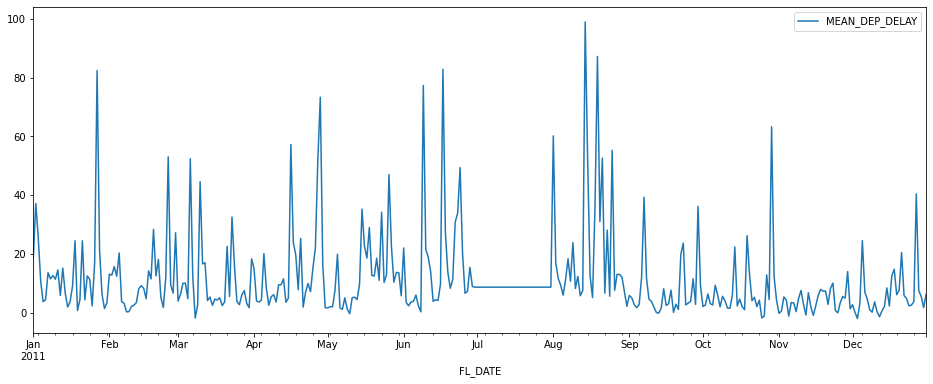

In [13]:
data.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

# Función para testear si un dataset es estacionario
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [15]:
#  Augmented Dickey-Fuller (ADF) test. Corroboramos que la serie es estacionaria
test_stationarity(data, 'MEAN_DEP_DELAY') 

'Stationary'

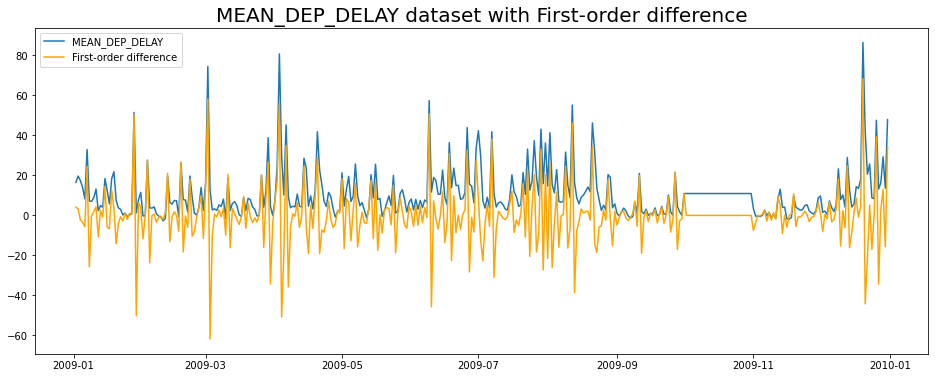

In [18]:
# Podemos comprobar también graficamente que la serie es estacionaria
# La curva actual y la de la 1er diferencia se acoplan muy bien!

# First-order difference
data['MEAN_DEP_DELAY_Diff'] = data['MEAN_DEP_DELAY'].diff(periods=1)
data = data.dropna()

# Plot
plt.title('MEAN_DEP_DELAY dataset with First-order difference', size=20)
plt.plot(data['MEAN_DEP_DELAY'], label='MEAN_DEP_DELAY')
plt.plot(data['MEAN_DEP_DELAY_Diff'], label='First-order difference', color='orange')
plt.legend();

In [13]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate autocorrelation
acf_values = acf(data['MEAN_DEP_DELAY'])
np.round(acf_values, 2)

array([ 1.  ,  0.44,  0.14,  0.08,  0.03, -0.01,  0.03,  0.02,  0.  ,
        0.01,  0.08,  0.  , -0.  , -0.01,  0.05,  0.11,  0.15,  0.03,
        0.  , -0.01, -0.1 , -0.07,  0.  , -0.02, -0.03, -0.01,  0.08,
        0.06,  0.02, -0.03, -0.06,  0.02,  0.03, -0.06, -0.07, -0.04,
       -0.04, -0.06, -0.07, -0.04, -0.01])

In [14]:
# Calculate partial autocorrelation
pacf_values = pacf(data['MEAN_DEP_DELAY'])
np.round(pacf_values, 2)

array([ 1.  ,  0.44, -0.06,  0.05, -0.02, -0.02,  0.06, -0.03,  0.01,
        0.01,  0.09, -0.08,  0.02, -0.02,  0.09,  0.09,  0.07, -0.09,
        0.01, -0.02, -0.12,  0.03,  0.02, -0.03, -0.02, -0.01,  0.12,
        0.  , -0.02, -0.06, -0.04,  0.07, -0.02, -0.09, -0.01,  0.04,
       -0.01, -0.08, -0.04,  0.06,  0.  ])

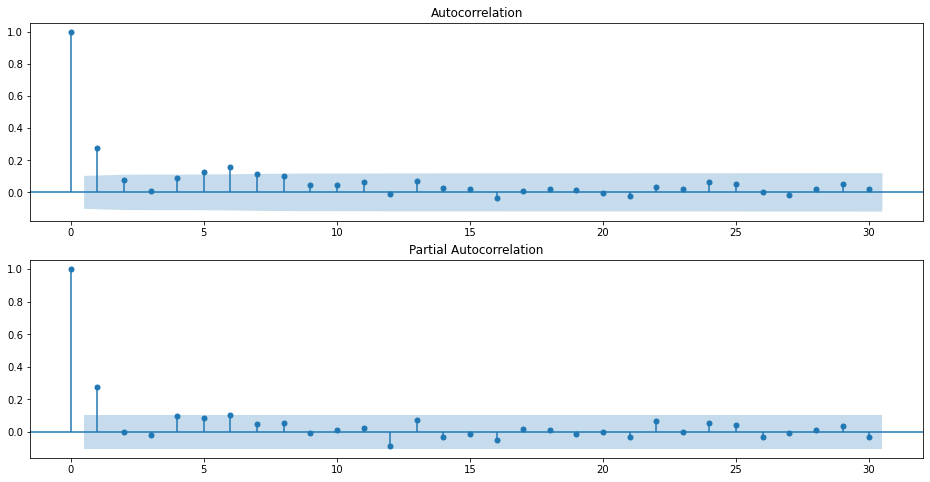

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# De las gráficas de autocorrelación se observa que la correlación más grande se da para el lag=1 (valor anterior)
# Acaso puede haber una correlación semanal (lag = 5 / 6) pero solo para 1 semana atrás porque luego los
# datos ingresan en la zona sombreada que no tiene significancia estadíatica
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['MEAN_DEP_DELAY'], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['MEAN_DEP_DELAY'], lags=30, ax=ax2)

In [15]:
# Como la serie es estacionaria aplicamos el modelo ARMA(p, q) = ARIMA (p, n=0, q)

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as tsa
from joblib import Parallel, delayed

max_p, max_q = 5, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets


def find_aic_for_model(data, p, n, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}\n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, q)
        ts_results = model(data, order=(p, 0, q)).fit(disp=False)
        curr_aic = ts_results.aic
        return curr_aic, (p, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, q)

    
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, 0, 1)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 0, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = Parallel(n_jobs=len(order_set), prefer='threads')(
                delayed(find_aic_for_model)(data, p, 0, q, model, model_name)
                for q in order_set
            )
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df


In [19]:
def get_order_sets2(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets

In [26]:
max_p, max_q = 5, 12
p_ar, q_ma = max_p, max_q

order_sets = get_order_sets2(q_ma, 5)
print(order_sets)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11]]


In [17]:
## SIN PROCESAMIENTO PARALELO

# Como la serie es estacionaria aplicamos el modelo ARMA(p, q) = ARIMA (p, n=0, q)

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as tsa

max_p, max_q = 5, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets


def find_aic_for_model(data, p, n, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}\n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, q)
        ts_results = model(data, order=(p, 0, q)).fit(disp=False)
        curr_aic = ts_results.aic
        return curr_aic, (p, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, q)

    
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, 0, 1)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 0, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = (find_aic_for_model(data, p, 0, q, model, model_name) for q in order_set)
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2011-01-01 to 2011-12-31
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MEAN_DEP_DELAY  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [19]:
# Hallamos el par (p, q) que minimiza el AIC (Akaike information criterion)
# El mínimo AIC señala el mejor modelo para el dataset

# Quitamos la columna MEAN_DEP_DELAY_Diff
#data.drop(['MEAN_DEP_DELAY_Diff'], axis=1, inplace=True)

min_aic, min_order, results_df = find_best_order_for_model(
    data, ARIMA, "ARMA"
)

print(f"min_aic: {min_aic}, min_order: {min_order}") 

Fitting ARMA with order p, q = (0, 0)

Fitting ARMA with order p, q = (0, 1)

Fitting ARMA with order p, q = (0, 2)

Fitting ARMA with order p, q = (0, 3)

Fitting ARMA with order p, q = (0, 4)

Fitting ARMA with order p, q = (1, 0)

Fitting ARMA with order p, q = (1, 1)

Fitting ARMA with order p, q = (1, 2)

Fitting ARMA with order p, q = (1, 3)

Fitting ARMA with order p, q = (1, 4)

Fitting ARMA with order p, q = (2, 0)

Fitting ARMA with order p, q = (2, 1)

Fitting ARMA with order p, q = (2, 2)

Fitting ARMA with order p, q = (2, 3)

Fitting ARMA with order p, q = (2, 4)

Fitting ARMA with order p, q = (3, 0)

Fitting ARMA with order p, q = (3, 1)

Fitting ARMA with order p, q = (3, 2)

Fitting ARMA with order p, q = (3, 3)

Fitting ARMA with order p, q = (3, 4)

Fitting ARMA with order p, q = (4, 0)

Fitting ARMA with order p, q = (4, 1)

Fitting ARMA with order p, q = (4, 2)

Fitting ARMA with order p, q = (4, 3)

Fitting ARMA with order p, q = (4, 4)

min_aic: 2970.64120323930

In [20]:
# Función para buscar anomalías
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [21]:
arma = tsa.ARIMA(data['MEAN_DEP_DELAY'], order=min_order)
arma_fit = arma.fit(disp=0)
squared_errors = arma_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors)

In [22]:
# Mostramos el threshold que clasifica las anomalías
print(f"threshold: {threshold}")

threshold: 918.1393607911303


In [23]:
# Vemos las frecuencias. El valor data['predictions']==1 corresponde a una anomalía. El valor 0 a un valor normal.
data['predictions'] = predictions
data['predictions'].value_counts()

0    347
1     18
Name: predictions, dtype: int64

In [24]:
# Anomalías encontradas
data[data['predictions']==1]

,MEAN_DEP_DELAY,predictions
FL_DATE,,
2011-01-27,82.413462,1
2011-02-25,53.083004,1
2011-03-06,52.430328,1
2011-03-10,44.616858,1
2011-04-16,57.280374,1
2011-04-27,52.129921,1
2011-04-28,73.339535,1
2011-05-26,47.052045,1
2011-06-09,77.332016,1


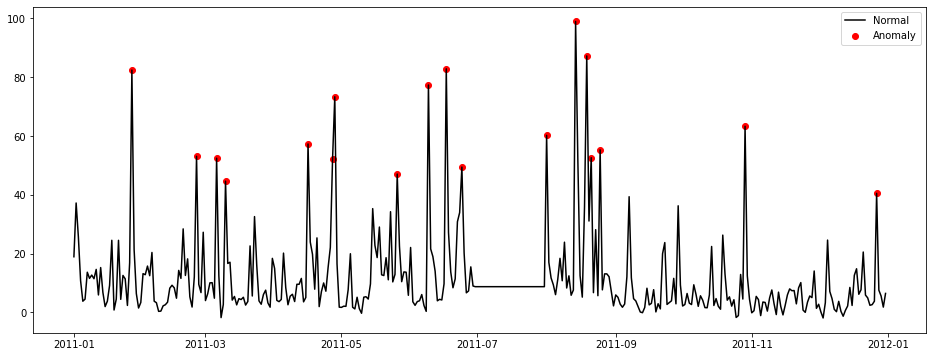

In [25]:
# visualization
fig, ax = plt.subplots(figsize=(16,6))

a = data.loc[data['predictions'] == 1, ['MEAN_DEP_DELAY']] #anomaly

ax.plot(data.index, data['MEAN_DEP_DELAY'], color='black', label = 'Normal')
ax.scatter(a.index,a['MEAN_DEP_DELAY'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# Algunas pruebas adicionales

In [110]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as tsa

data2 = data['MEAN_DEP_DELAY'].squeeze()

order=(2, 0, 0)
arma_mod20 = tsa.ARIMA(data2, order=order).fit(disp=0)
curr_aic = arma_mod20.aic
print(f"AIC: {curr_aic}, order: {order}")

AIC: 3101.4860527382975, order: (2, 0, 0)


In [111]:
print(arma_mod20.params)

const                   12.403745
ar.L1.MEAN_DEP_DELAY     0.460848
ar.L2.MEAN_DEP_DELAY     0.016148
dtype: float64


In [112]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

3101.4860527382975 3117.0856421526273 3107.685532362797


In [113]:
order=(3, 0, 0)
arma_mod30 = tsa.ARIMA(data2, order=order).fit(disp=0)
curr_aic = arma_mod30.aic
print(f"AIC: {curr_aic}, order: {order}")

AIC: 3103.4721518267356, order: (3, 0, 0)


In [114]:
print(arma_mod30.params)

const                   12.403512
ar.L1.MEAN_DEP_DELAY     0.460745
ar.L2.MEAN_DEP_DELAY     0.013301
ar.L3.MEAN_DEP_DELAY     0.006150
dtype: float64


In [115]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

3103.4721518267356 3122.971638594648 3111.22150135736
